In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

print(keras.__version__)

2.6.0


In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

# Specify patient_ids to remove
patient_ids_to_remove = ['006388', '008e5c', '00c058', '01adc5']

# Filter out the rows with specified patient_ids
train_df = train_df[~train_df['patient_id'].isin(patient_ids_to_remove)].reset_index(drop=True)

# Print the cleaned DataFrame
print("Cleaned DataFrame:")
print(train_df.head())

Cleaned DataFrame:
   image_id  center_id patient_id  image_num label
0  026c97_0          4     026c97          0    CE
1  028989_0          5     028989          0   LAA
2  029c68_0          5     029c68          0    CE
3  032f10_0          7     032f10          0    CE
4  0372b0_0          7     0372b0          0    CE


## Data viusalization

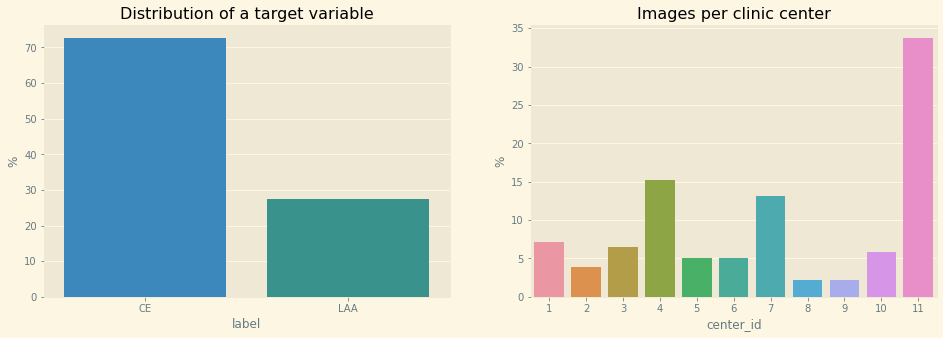

Train Size = 750
Test Size = 4


In [3]:
##### CLASS DISTRIBUTION

plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [5]:
import random

train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

# Specify patient_ids to remove
patient_ids_to_remove = ['006388', '008e5c', '00c058', '01adc5']

# Filter out the rows with specified patient_ids
train_df = train_df[~train_df['patient_id'].isin(patient_ids_to_remove)].reset_index(drop=True)

df1 = train_df[train_df['label'] == 'CE']
df2 = train_df[train_df['label'] == 'LAA']
#adjust n to change number of CE data
sampled= df1.sample(n=200, random_state=42)
train_df = pd.concat([sampled, df2],ignore_index=True)
# Print the cleaned DataFrame
print("Cleaned DataFrame:")
print(train_df.head())
train_df['label'].value_counts()

Cleaned DataFrame:
   image_id  center_id patient_id  image_num label
0  8ebb0c_0          1     8ebb0c          0    CE
1  2244d2_0         11     2244d2          0    CE
2  a59c0d_0          6     a59c0d          0    CE
3  280c26_0          7     280c26          0    CE
4  e9c181_1         10     e9c181          1    CE


LAA    205
CE     200
Name: label, dtype: int64

In [6]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE
1,028989_0,32789,85695,1721.26,/kaggle/input/mayo-clinic-strip-ai/train/02898...,0.382624,5,028989,0,LAA
2,032f10_0,6598,28652,92.76,/kaggle/input/mayo-clinic-strip-ai/train/032f1...,0.230281,7,032f10,0,CE
3,0372b0_0,4841,25138,45.77,/kaggle/input/mayo-clinic-strip-ai/train/0372b...,0.192577,7,0372b0,0,CE
4,03d1ec_0,23125,30421,237.11,/kaggle/input/mayo-clinic-strip-ai/train/03d1e...,0.760166,11,03d1ec,0,LAA


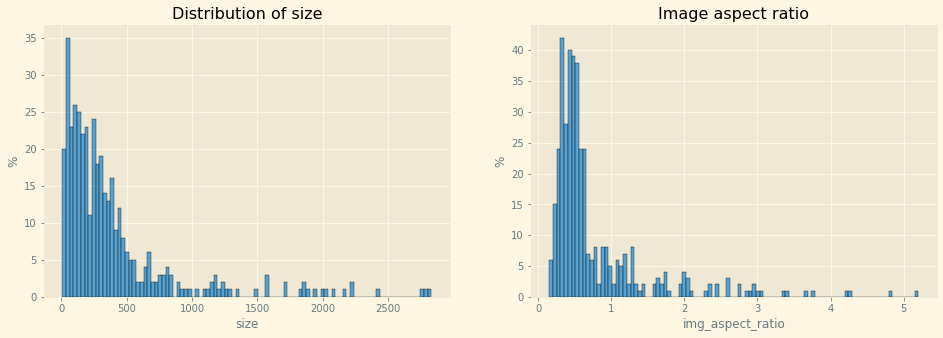

In [7]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

In [8]:
# fig, axes = plt.subplots(1,5, figsize=(16,16))
# train_images
# for ax in axes.reshape(-1):
#     img_path = np.random.choice(LAA_imgs)
#     img = Image.open(img_path)   
#     img.thumbnail((300,300), Image.Resampling.LANCZOS)
#     ax.imshow(img), ax.set_title("target: LAA")
# plt.show()

## First impressions:

- Images sizes are from small ones to a high-resolution ones
- Images have different aspect ratios
- Backgrounds have different colours
- Clots are usually in the form of multiple small pieces
- Blood clots have different colours

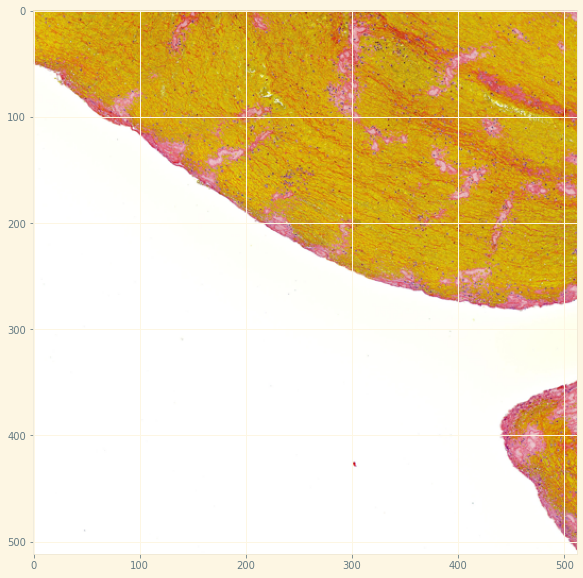

In [9]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


![image](https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg)

## Approach 1

## Loading Data

In [10]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [11]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,8ebb0c_0,1,8ebb0c,0,CE,../input/mayo-clinic-strip-ai/train/8ebb0c_0.tif,1
1,2244d2_0,11,2244d2,0,CE,../input/mayo-clinic-strip-ai/train/2244d2_0.tif,1
2,a59c0d_0,6,a59c0d,0,CE,../input/mayo-clinic-strip-ai/train/a59c0d_0.tif,1
3,280c26_0,7,280c26,0,CE,../input/mayo-clinic-strip-ai/train/280c26_0.tif,1
4,e9c181_1,10,e9c181,1,CE,../input/mayo-clinic-strip-ai/train/e9c181_1.tif,1


## Preprocessing

In [12]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 405/405 [25:01<00:00,  3.71s/it]

CPU times: user 8min 39s, sys: 2min 3s, total: 10min 43s
Wall time: 25min 1s


In [13]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.3, random_state=42)

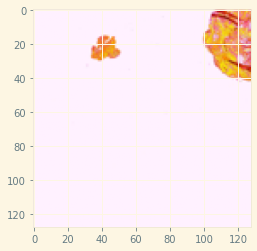

In [14]:
plt.imshow(x_train[0])

In [15]:
# import os
# # os.mkdir("image")
# # os.mkdir("image/CE")
# # os.mkdir("image/LAA")
# # cwd = os.getcwd()
# # print(os.listdir(cwd))
# import shutil
# for i in range(len(train_df.iloc[:,4])):
#     if train_df.iloc[i,4] == "CE":
#         shutil.copy(f"/kaggle/input/mayo-clinic-strip-ai/train/{train_df.iloc[i,0]}.tif",f'image/CE/{train_df.iloc[i,0]}.tif')
#     else:
#         shutil.copy(f"/kaggle/input/mayo-clinic-strip-ai/train/{train_df.iloc[i,0]}.tif",f'image/LAA/{train_df.iloc[i,0]}.tif')

In [16]:
# import glob 
# print(glob.glob("image/CE/*"))
# print(train_df.iloc[0,0])

In [17]:
# from keras.preprocessing.image import ImageDataGenerator

# X_train = ImageDataGenerator(
#     rescale=1. / 255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     width_shift_range= 0.1,
#     height_shift_range= 0.1,
#     horizontal_flip=True,
#     )
# train_generator = X_train.flow_from_directory(
#     "image/",
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='binary')

In [18]:
# X_train=[]
# for i in tqdm(train_df['file_path']):
#     x1=preprocess(i)
#     X_train.append(x1)

# Y_train=[]    
# Y_train=train_df['target']

In [19]:
# X_train= np.array(X_train)
# X_train= X_train/255.0
# Y_train = np.array(Y_train)

In [20]:
# ## Splitting data
# x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [21]:
# ## Splitting data
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train, test_size=0.5, random_state=42)

In [22]:
# print(x_train.shape)

In [23]:
# plt.imshow(x_train[0])

## Our CNN approach

In [24]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [25]:
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=128, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=16, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())


# model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.13))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-6))

dot_img_file = 'model.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [26]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 0.9878048780487805, 1: 1.0125}


In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
model.fit(
    x_train,
    y_train,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1 
)

Epoch 1/100
7/7 [==============================] - 9s 137ms/step - loss: 0.6916 - binary_accuracy: 0.5297 - f1_score: 0.2047 - val_loss: 0.6933 - val_binary_accuracy: 0.4828 - val_f1_score: 0.0448
Epoch 2/100
7/7 [==============================] - 0s 34ms/step - loss: 0.6874 - binary_accuracy: 0.5396 - f1_score: 0.1479 - val_loss: 0.6935 - val_binary_accuracy: 0.4680 - val_f1_score: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 33ms/step - loss: 0.6891 - binary_accuracy: 0.5396 - f1_score: 0.1897 - val_loss: 0.6944 - val_binary_accuracy: 0.4680 - val_f1_score: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 33ms/step - loss: 0.6959 - binary_accuracy: 0.5000 - f1_score: 0.0724 - val_loss: 0.6949 - val_binary_accuracy: 0.4680 - val_f1_score: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 32ms/step - loss: 0.6872 - binary_accuracy: 0.5792 - f1_score: 0.2981 - val_loss: 0.6953 - val_binary_accuracy: 0.4680 - val_f1_score: 0.0000e+00
Epo

In [28]:
best_cnn = load_model('/kaggle/working/best_model.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

4/4 [==============================] - 0s 28ms/step - loss: 0.6932 - binary_accuracy: 0.4918 - f1_score: 0.0521


[0.6932304501533508, 0.49180328845977783, 0.052139028906822205]

Text(0.5, 24.0, 'Actual')

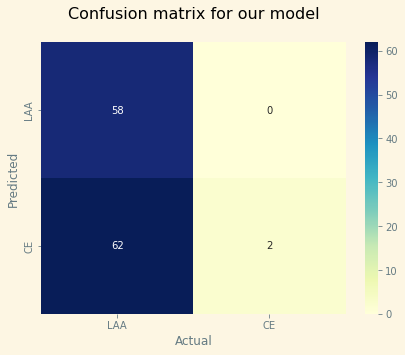

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")


In [30]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# from keras import metrics

# model = Sequential()
# input_shape = (128, 128, 4)

# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128, 128, 4)))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.13))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(
#     loss = tf.keras.losses.BinaryCrossentropy(),
#     metrics=[metrics.binary_accuracy,f1_score],
#     optimizer = tf.keras.optimizers.Adam(1e-3))

# model.summary()

# from keras.callback import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# nb_train_samples = len(x_train)
# nb_validation_samples = len(x_val)
# batch_size = 32
# def call_train(number):
#     earlystop = EarlyStopping(monitor='accuracy', min_delta=0.1, patience=2, verbose=1, mode='max')
#     checkpoint = ModelCheckpoint(f"cnn{number}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False,
#                                  mode='max', period=1)
#     RL = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min')
#     model.fit_generator(generator=train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=number, validation_data=(x_val,y_val),
#                               validation_steps=nb_validation_samples//batch_size, callbacks=[checkpoint, RL, earlystop])
#     model.save(f"cnn{number}.h5")

# call_train(20)



# from sklearn.utils import compute_class_weight
# from keras.callbacks import ModelCheckpoint

# # Calculate class weights for handling class imbalance
# train_classes = Y_train
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(train_classes),
#     y=train_classes
# )
# class_weights = dict(zip(np.unique(train_classes), class_weights))

# # Set up a callback to save the best model during training
# callback = ModelCheckpoint(
#     filepath='our_cnn_best.h5',
#     monitor='val_binary_accuracy',
#     mode='max',
#     save_best_only=True,
#     verbose=1
# )

# # Train the model
# history = model.fit(
#     x_train,
#     y_train,
#     epochs=10,
#     batch_size=20,
#     validation_data=(x_test, y_test),
#     class_weight=class_weights,
#     callbacks=[callback]
# )

# # Load the best model
# best_cnn = load_model('our_cnn_best.h5', custom_objects={"f1_score": f1_score})

# # Evaluate the model on the test set
# test_loss, test_acc, test_f1 = best_cnn.evaluate(x_test, y_test)
# print(f"Test Accuracy: {test_acc}, Test F1 Score: {test_f1}")